# Detecting Suspicious Bitcoin Transactions: A GNN-Based Approach Using the Elliptic Dataset

In [1]:
!pip install pandas numpy matplotlib networkx scikit-learn

## Elliptic dataset enumeration

### Loading Data

In [2]:
import pandas as pd

edges = pd.read_csv("elliptic_txs_edgelist.csv", sep=",", header=None, names=["src", "dst"])
features = pd.read_csv("elliptic_txs_features.csv", header=None)
labels = pd.read_csv("elliptic_txs_classes.csv", header=None, names=["tx_id", "class"])

### Convert all Tags to "str" Format

In [3]:
labels['class'] = labels['class'].astype(str)

### Counting Members of Each Class

In [4]:
label_counts = labels['class'].value_counts()

### Keep Known Classes

In [5]:
label_map = {'1': 'illicit', '2': 'legal', 'unknown': 'unknown'}
label_counts = label_counts[label_counts.index.isin(label_map.keys())]

### Change to Practical Names

In [6]:
label_counts.index = [label_map[l] for l in label_counts.index]

### Bar Chart

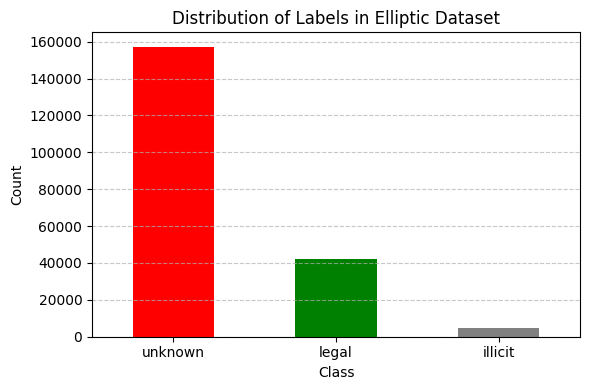

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['red', 'green', 'gray'])
plt.title("Distribution of Labels in Elliptic Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### PCA & t-SNE

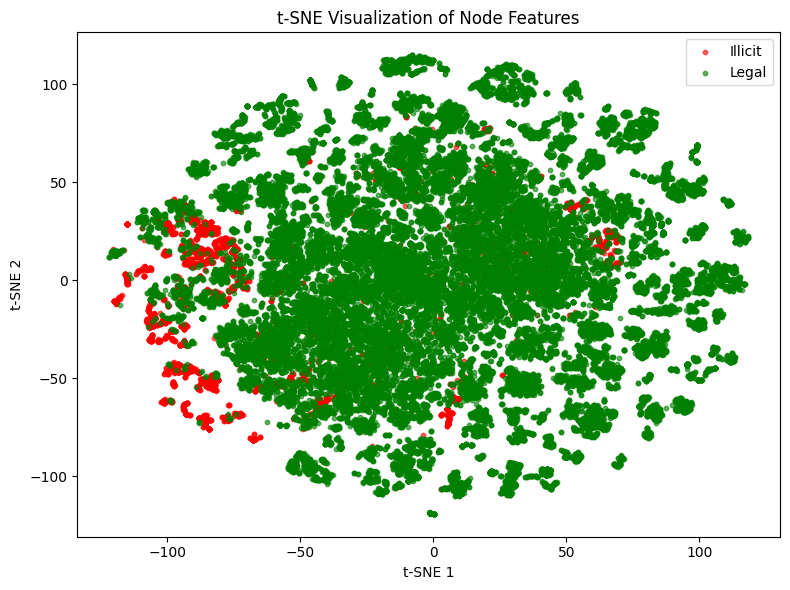

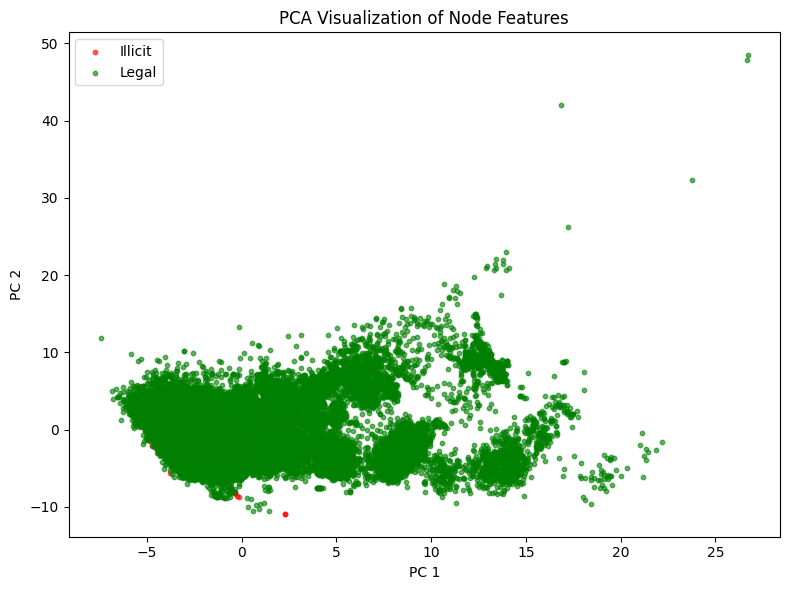

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = pd.read_csv("elliptic_txs_features.csv", header=None)
labels = pd.read_csv("elliptic_txs_classes.csv", header=None, names=["tx_id", "class"])

features[0] = features[0].astype(str)
labels["tx_id"] = labels["tx_id"].astype(str)

features.columns = ["tx_id"] + list(range(1, 167))
data = features.merge(labels, how="left", on="tx_id")

labeled_data = data[data["class"].isin(["1", "2"])]
X = labeled_data.loc[:, 1:166].values
y = labeled_data["class"].values

X_scaled = StandardScaler().fit_transform(X)

color_map = {"1": "red", "2": "green"}
label_names = {"1": "Illicit", "2": "Legal"}
colors = [color_map[c] for c in y]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for class_label in ["1", "2"]:
    idx = y == class_label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=color_map[class_label],
                label=label_names[class_label], alpha=0.6, s=10)
plt.title("t-SNE Visualization of Node Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for class_label in ["1", "2"]:
    idx = y == class_label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color_map[class_label],
                label=label_names[class_label], alpha=0.6, s=10)
plt.title("PCA Visualization of Node Features")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.tight_layout()
plt.show()

## Preprocess Data

### Load Libraries

In [10]:
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load Data (again!)

In [11]:
edges = pd.read_csv("elliptic_txs_edgelist.csv", header=None, names=["src", "dst"])
features = pd.read_csv("elliptic_txs_features.csv", header=None)
labels = pd.read_csv("elliptic_txs_classes.csv", header=None, names=["tx_id", "class"])

### Convert to "str" Format

In [16]:
features[0] = features[0].astype(str)
labels["tx_id"] = labels["tx_id"].astype(str)

### Assign Numeric IDs

In [17]:
node_ids = features[0].values
id_map = {tx_id: idx for idx, tx_id in enumerate(node_ids)}

### Constructing the Feature Matrix "X"

In [18]:
X = features.iloc[:, 1:].values
X = StandardScaler().fit_transform(X)
x = torch.tensor(X, dtype=torch.float)

### Constructing the Feature Tensor "Y"

In [20]:
labels_dict = labels.set_index("tx_id")["class"].to_dict()
y = torch.full((len(features),), -1, dtype=torch.long)

for tx_id, label in labels_dict.items():
    if tx_id in id_map:
        idx = id_map[tx_id]
        if label == "1":
            y[idx] = 1  # illicit
        elif label == "2":
            y[idx] = 0  # legal

### Constructing the "edge_index" Tensor

In [21]:
edge_index_df = edges[edges["src"].isin(id_map) & edges["dst"].isin(id_map)].copy()
edge_index_df["src"] = edge_index_df["src"].map(id_map)
edge_index_df["dst"] = edge_index_df["dst"].map(id_map)
edge_index = torch.tensor(edge_index_df.values.T, dtype=torch.long)

### Labeled Node Splitting (Train/Val/Test)

In [23]:
labeled_nodes = (y != -1).nonzero(as_tuple=True)[0]
train_idx, test_idx = train_test_split(labeled_nodes, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)

train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

### Creating PyG Data object

In [26]:
data = Data(x=x, edge_index=edge_index, y=y,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
print(data)

Data(x=[203769, 166], edge_index=[2, 234355], y=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769])


## Defining the Model Architecture

### Import Libraries

In [27]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

### Creating GCN Class (model)

In [28]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## Train the Model

### Set device, model & data

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.num_features, hidden_channels=64, out_channels=2).to(device)
data = data.to(device)

### Set Optimizer

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

### Set Loss Function

In [32]:
criterion = nn.CrossEntropyLoss()

### Define the "train" Function

In [34]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

### Define Evaluation Function

In [35]:
@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)

    def acc(mask):
        correct = pred[mask] == data.y[mask]
        return int(correct.sum()) / int(mask.sum())

    return acc(data.train_mask), acc(data.val_mask), acc(data.test_mask)

### Train Loop

In [36]:
for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 010 | Loss: 0.3141 | Train Acc: 0.9206 | Val Acc: 0.9196 | Test Acc: 0.9193
Epoch 020 | Loss: 0.2382 | Train Acc: 0.9360 | Val Acc: 0.9340 | Test Acc: 0.9327
Epoch 030 | Loss: 0.2078 | Train Acc: 0.9413 | Val Acc: 0.9406 | Test Acc: 0.9382
Epoch 040 | Loss: 0.1892 | Train Acc: 0.9425 | Val Acc: 0.9408 | Test Acc: 0.9409
Epoch 050 | Loss: 0.1740 | Train Acc: 0.9466 | Val Acc: 0.9423 | Test Acc: 0.9435
Epoch 060 | Loss: 0.1677 | Train Acc: 0.9482 | Val Acc: 0.9459 | Test Acc: 0.9459
Epoch 070 | Loss: 0.1623 | Train Acc: 0.9500 | Val Acc: 0.9456 | Test Acc: 0.9463
Epoch 080 | Loss: 0.1553 | Train Acc: 0.9513 | Val Acc: 0.9491 | Test Acc: 0.9479
Epoch 090 | Loss: 0.1543 | Train Acc: 0.9524 | Val Acc: 0.9496 | Test Acc: 0.9477
Epoch 100 | Loss: 0.1497 | Train Acc: 0.9521 | Val Acc: 0.9495 | Test Acc: 0.9495


## Visualize Node Embeddings

### Extracting Node Embeddings

In [37]:

@torch.no_grad()
def get_node_embeddings():
    model.eval()
    x, edge_index = data.x, data.edge_index
    x = model.conv1(x, edge_index)
    x = F.relu(x)
    return x.cpu()

embeddings = get_node_embeddings()

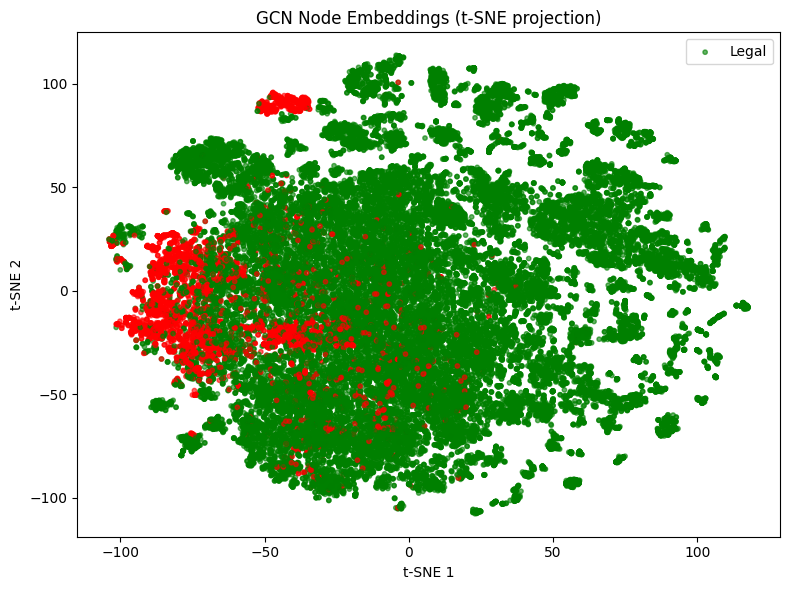

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

labels_np = data.y.cpu().numpy()
mask = labels_np != -1

X = embeddings[mask].numpy()
y = labels_np[mask]

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

colors = ['green' if label == 0 else 'red' for label in y]

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.6, s=10)
plt.title("GCN Node Embeddings (t-SNE projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(['Legal', 'Illicit'])
plt.tight_layout()
plt.show()
